# Cross-Cohort Signature Correspondence Analysis

This notebook quantifies the reproducibility of disease signatures across biobanks (UK Biobank, Mass General Brigham, All of Us) using:

1. **Cross-tabulation matrices**: Normalized confusion matrices showing cluster correspondence
2. **Modified Jaccard similarity**: Set-based metric for quantifying signature overlap

**Key metric**: Median modified Jaccard similarity = 0.800 (80.0%) across all UKB signatures


## Setup and Data Loading


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# Output directory
OUTPUT_DIR = Path('.')
OUTPUT_DIR.mkdir(exist_ok=True)

print("Setup complete")


Setup complete


In [28]:
mgb_checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt'

In [29]:
# Load model checkpoints
print("="*80)
print("LOADING MODEL CHECKPOINTS")
print("="*80)

ukb_checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt'
mgb_checkpoint_path = '/Users/sarahurbut/Dropbox-Personal/model_with_kappa_bigam_MGB.pt'
aou_checkpoint_path = '/Users/sarahurbut/Dropbox-Personal/model_with_kappa_bigam_AOU.pt'

ukb_checkpoint = torch.load(ukb_checkpoint_path, map_location='cpu')
mgb_checkpoint = torch.load(mgb_checkpoint_path, map_location='cpu')
aou_checkpoint = torch.load(aou_checkpoint_path, map_location='cpu')

print(f"\n✓ UKB checkpoint loaded")
print(f"✓ MGB checkpoint loaded")
print(f"✓ AoU checkpoint loaded")

# Extract disease names and clusters
ukb_diseases = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/disease_names.csv')['x']
mgb_diseases = mgb_checkpoint['disease_names']
aou_diseases = aou_checkpoint['disease_names']

ukb_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
mgb_clusters = mgb_checkpoint['clusters']
aou_clusters = aou_checkpoint['clusters']

# Convert to lists if needed
if hasattr(ukb_diseases, 'values'):
    ukb_diseases = ukb_diseases.values.tolist()
if hasattr(mgb_diseases, 'values'):
    mgb_diseases = mgb_diseases.values.tolist()
if hasattr(aou_diseases, 'values'):
    aou_diseases = aou_diseases.values.tolist()

# Convert clusters to numpy arrays if needed
if isinstance(ukb_clusters, torch.Tensor):
    ukb_clusters = ukb_clusters.numpy()
if isinstance(mgb_clusters, torch.Tensor):
    mgb_clusters = mgb_clusters.numpy()
if isinstance(aou_clusters, torch.Tensor):
    aou_clusters = aou_clusters.numpy()

print(f"\nUKB: {len(ukb_diseases)} diseases, {ukb_clusters.max()+1} signatures")
print(f"MGB: {len(mgb_diseases)} diseases, {mgb_clusters.max()+1} signatures")
print(f"AoU: {len(aou_diseases)} diseases, {aou_clusters.max()+1} signatures")


LOADING MODEL CHECKPOINTS

✓ UKB checkpoint loaded
✓ MGB checkpoint loaded
✓ AoU checkpoint loaded

UKB: 348 diseases, 20 signatures
MGB: 346 diseases, 20 signatures
AoU: 348 diseases, 20 signatures


## Create DataFrames and Find Common Diseases


In [30]:
# Create DataFrames for each biobank
ukb_df = pd.DataFrame({
    'Disease': ukb_diseases,
    'UKB_cluster': ukb_clusters
})

mgb_df = pd.DataFrame({
    'Disease': mgb_diseases,
    'MGB_cluster': mgb_clusters
})

aou_df = pd.DataFrame({
    'Disease': aou_diseases,
    'AoU_cluster': aou_clusters
})

# Find common diseases between biobanks
common_ukb_mgb = list(set(ukb_diseases) & set(mgb_diseases))
common_ukb_aou = list(set(ukb_diseases) & set(aou_diseases))
common_all_three = list(set(ukb_diseases) & set(mgb_diseases) & set(aou_diseases))

print("="*80)
print("COMMON DISEASES")
print("="*80)
print(f"\nUKB ↔ MGB: {len(common_ukb_mgb)} common diseases")
print(f"UKB ↔ AoU: {len(common_ukb_aou)} common diseases")
print(f"All three biobanks: {len(common_all_three)} common diseases")


COMMON DISEASES

UKB ↔ MGB: 346 common diseases
UKB ↔ AoU: 348 common diseases
All three biobanks: 346 common diseases


## Cross-Tabulation Matrices


In [31]:
# Create cross-tabulation matrices (normalized by row)
print("="*80)
print("CROSS-TABULATION MATRICES")
print("="*80)

# Merge dataframes for common diseases
df_ukb_mgb = pd.DataFrame({'Disease': common_ukb_mgb})
df_ukb_mgb = df_ukb_mgb.merge(ukb_df, on='Disease', how='left')
df_ukb_mgb = df_ukb_mgb.merge(mgb_df, on='Disease', how='left')

df_ukb_aou = pd.DataFrame({'Disease': common_ukb_aou})
df_ukb_aou = df_ukb_aou.merge(ukb_df, on='Disease', how='left')
df_ukb_aou = df_ukb_aou.merge(aou_df, on='Disease', how='left')

# Create cross-tabulation matrices (normalized by row)
cross_tab_mgb = pd.crosstab(
    df_ukb_mgb['UKB_cluster'], 
    df_ukb_mgb['MGB_cluster'], 
    normalize='index'
)

cross_tab_aou = pd.crosstab(
    df_ukb_aou['UKB_cluster'], 
    df_ukb_aou['AoU_cluster'], 
    normalize='index'
)

print(f"\n✓ Cross-tabulation matrix (UKB vs MGB): {cross_tab_mgb.shape}")
print(f"✓ Cross-tabulation matrix (UKB vs AoU): {cross_tab_aou.shape}")

# Find best matches for ordering
best_matches_mgb = pd.DataFrame({
    'UKB': cross_tab_mgb.index,
    'MGB': cross_tab_mgb.idxmax(axis=1),
    'Proportion': cross_tab_mgb.max(axis=1).values
}).sort_values('MGB')

best_matches_aou = pd.DataFrame({
    'UKB': cross_tab_aou.index,
    'AoU': cross_tab_aou.idxmax(axis=1),
    'Proportion': cross_tab_aou.max(axis=1).values
}).sort_values('AoU')

print(f"\n✓ Best matches identified for visualization")


CROSS-TABULATION MATRICES

✓ Cross-tabulation matrix (UKB vs MGB): (20, 20)
✓ Cross-tabulation matrix (UKB vs AoU): (20, 20)

✓ Best matches identified for visualization


## Calculate Modified Jaccard Similarity

The modified Jaccard similarity for each UKB cluster $k$ is defined as:

$$J_k = \\frac{|D_{k,\\text{UKB}} \\cap D_{k^*,\\text{other}}|}{|D_{k,\\text{UKB}}|}$$

where:
- $D_{k,\\text{UKB}}$ is the set of diseases in UKB cluster $k$
- $D_{k^*,\\text{other}}$ is the set of diseases in the best-matching cluster $k^*$ in the comparison cohort
- $|\\cdot|$ denotes set cardinality

The overall cross-cohort similarity is the **median** of these cluster-specific similarities.


In [32]:
def calculate_modified_jaccard(ukb_df, other_df, other_col_name, common_diseases, biobank_name):
    """
    Calculate modified Jaccard similarity using set intersections.
    
    For each UKB cluster k:
    1. Get set of diseases in UKB cluster k (from common diseases)
    2. For each cluster in other biobank, calculate intersection
    3. Find best-matching cluster (maximum intersection / UKB cluster size)
    4. Store Jaccard score for cluster k
    
    Returns:
    --------
    jaccard_scores : list
        List of Jaccard scores for each UKB cluster
    cluster_details : dict
        Dictionary with details for each cluster
    """
    # Merge on common diseases
    merged = ukb_df[ukb_df['Disease'].isin(common_diseases)].merge(
        other_df[other_df['Disease'].isin(common_diseases)],
        on='Disease', how='inner'
    )
    
    # Group by UKB cluster
    jaccard_scores = []
    cluster_details = {}
    
    for ukb_cluster in sorted(merged['UKB_cluster'].unique()):
        ukb_diseases = set(merged[merged['UKB_cluster'] == ukb_cluster]['Disease'])
        if len(ukb_diseases) == 0:
            continue
            
        # Find best matching cluster in other biobank
        best_match_score = 0
        best_match_cluster = None
        best_intersection = set()
        
        for other_cluster in sorted(merged[other_col_name].unique()):
            other_diseases = set(merged[merged[other_col_name] == other_cluster]['Disease'])
            intersection = ukb_diseases & other_diseases
            jaccard_k = len(intersection) / len(ukb_diseases)
            
            if jaccard_k > best_match_score:
                best_match_score = jaccard_k
                best_match_cluster = other_cluster
                best_intersection = intersection
        
        jaccard_scores.append(best_match_score)
        cluster_details[ukb_cluster] = {
            'jaccard': best_match_score,
            'best_match': best_match_cluster,
            'ukb_size': len(ukb_diseases),
            'intersection_size': len(best_intersection)
        }
        
        print(f"  UKB cluster {ukb_cluster:2d} → {biobank_name} cluster {best_match_cluster:2d}: "
              f"J = {best_match_score:.3f} ({len(best_intersection)}/{len(ukb_diseases)} diseases)")
    
    return jaccard_scores, cluster_details

print("="*80)
print("MODIFIED JACCARD SIMILARITY CALCULATION")
print("="*80)

print("\n" + "-"*80)
print("UKB ↔ MGB:")
print("-"*80)
jaccard_mgb, details_mgb = calculate_modified_jaccard(
    ukb_df, mgb_df, 'MGB_cluster', common_ukb_mgb, 'MGB'
)

print("\n" + "-"*80)
print("UKB ↔ AoU:")
print("-"*80)
jaccard_aou, details_aou = calculate_modified_jaccard(
    ukb_df, aou_df, 'AoU_cluster', common_ukb_aou, 'AoU'
)

# Calculate summary statistics
median_mgb = np.median(jaccard_mgb)
median_aou = np.median(jaccard_aou)
combined_median = np.median(jaccard_mgb + jaccard_aou)
average_medians = (median_mgb + median_aou) / 2

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nMedian Jaccard (UKB ↔ MGB): {median_mgb:.3f} ({median_mgb*100:.1f}%)")
print(f"Median Jaccard (UKB ↔ AoU): {median_aou:.3f} ({median_aou*100:.1f}%)")
print(f"\nCombined median Jaccard: {combined_median:.3f} ({combined_median*100:.1f}%)")
print(f"Average of medians: {average_medians:.3f} ({average_medians*100:.1f}%)")
print(f"\nIQR (UKB ↔ MGB): [{np.percentile(jaccard_mgb, 25):.3f}, {np.percentile(jaccard_mgb, 75):.3f}]")
print(f"IQR (UKB ↔ AoU): [{np.percentile(jaccard_aou, 25):.3f}, {np.percentile(jaccard_aou, 75):.3f}]")


MODIFIED JACCARD SIMILARITY CALCULATION

--------------------------------------------------------------------------------
UKB ↔ MGB:
--------------------------------------------------------------------------------
  UKB cluster  0 → MGB cluster  5: J = 0.929 (13/14 diseases)
  UKB cluster  1 → MGB cluster  2: J = 0.952 (20/21 diseases)
  UKB cluster  2 → MGB cluster  7: J = 0.933 (14/15 diseases)
  UKB cluster  3 → MGB cluster 12: J = 0.561 (46/82 diseases)
  UKB cluster  4 → MGB cluster  0: J = 1.000 (5/5 diseases)
  UKB cluster  5 → MGB cluster  5: J = 0.571 (4/7 diseases)
  UKB cluster  6 → MGB cluster 11: J = 0.875 (7/8 diseases)
  UKB cluster  7 → MGB cluster  1: J = 0.500 (11/22 diseases)
  UKB cluster  8 → MGB cluster 19: J = 0.679 (19/28 diseases)
  UKB cluster  9 → MGB cluster  9: J = 1.000 (12/12 diseases)
  UKB cluster 10 → MGB cluster 16: J = 1.000 (11/11 diseases)
  UKB cluster 11 → MGB cluster 10: J = 0.875 (7/8 diseases)
  UKB cluster 12 → MGB cluster  3: J = 0.714 (5/7 

✓ Saved heatmaps to: cross_cohort_correspondence_heatmaps.pdf


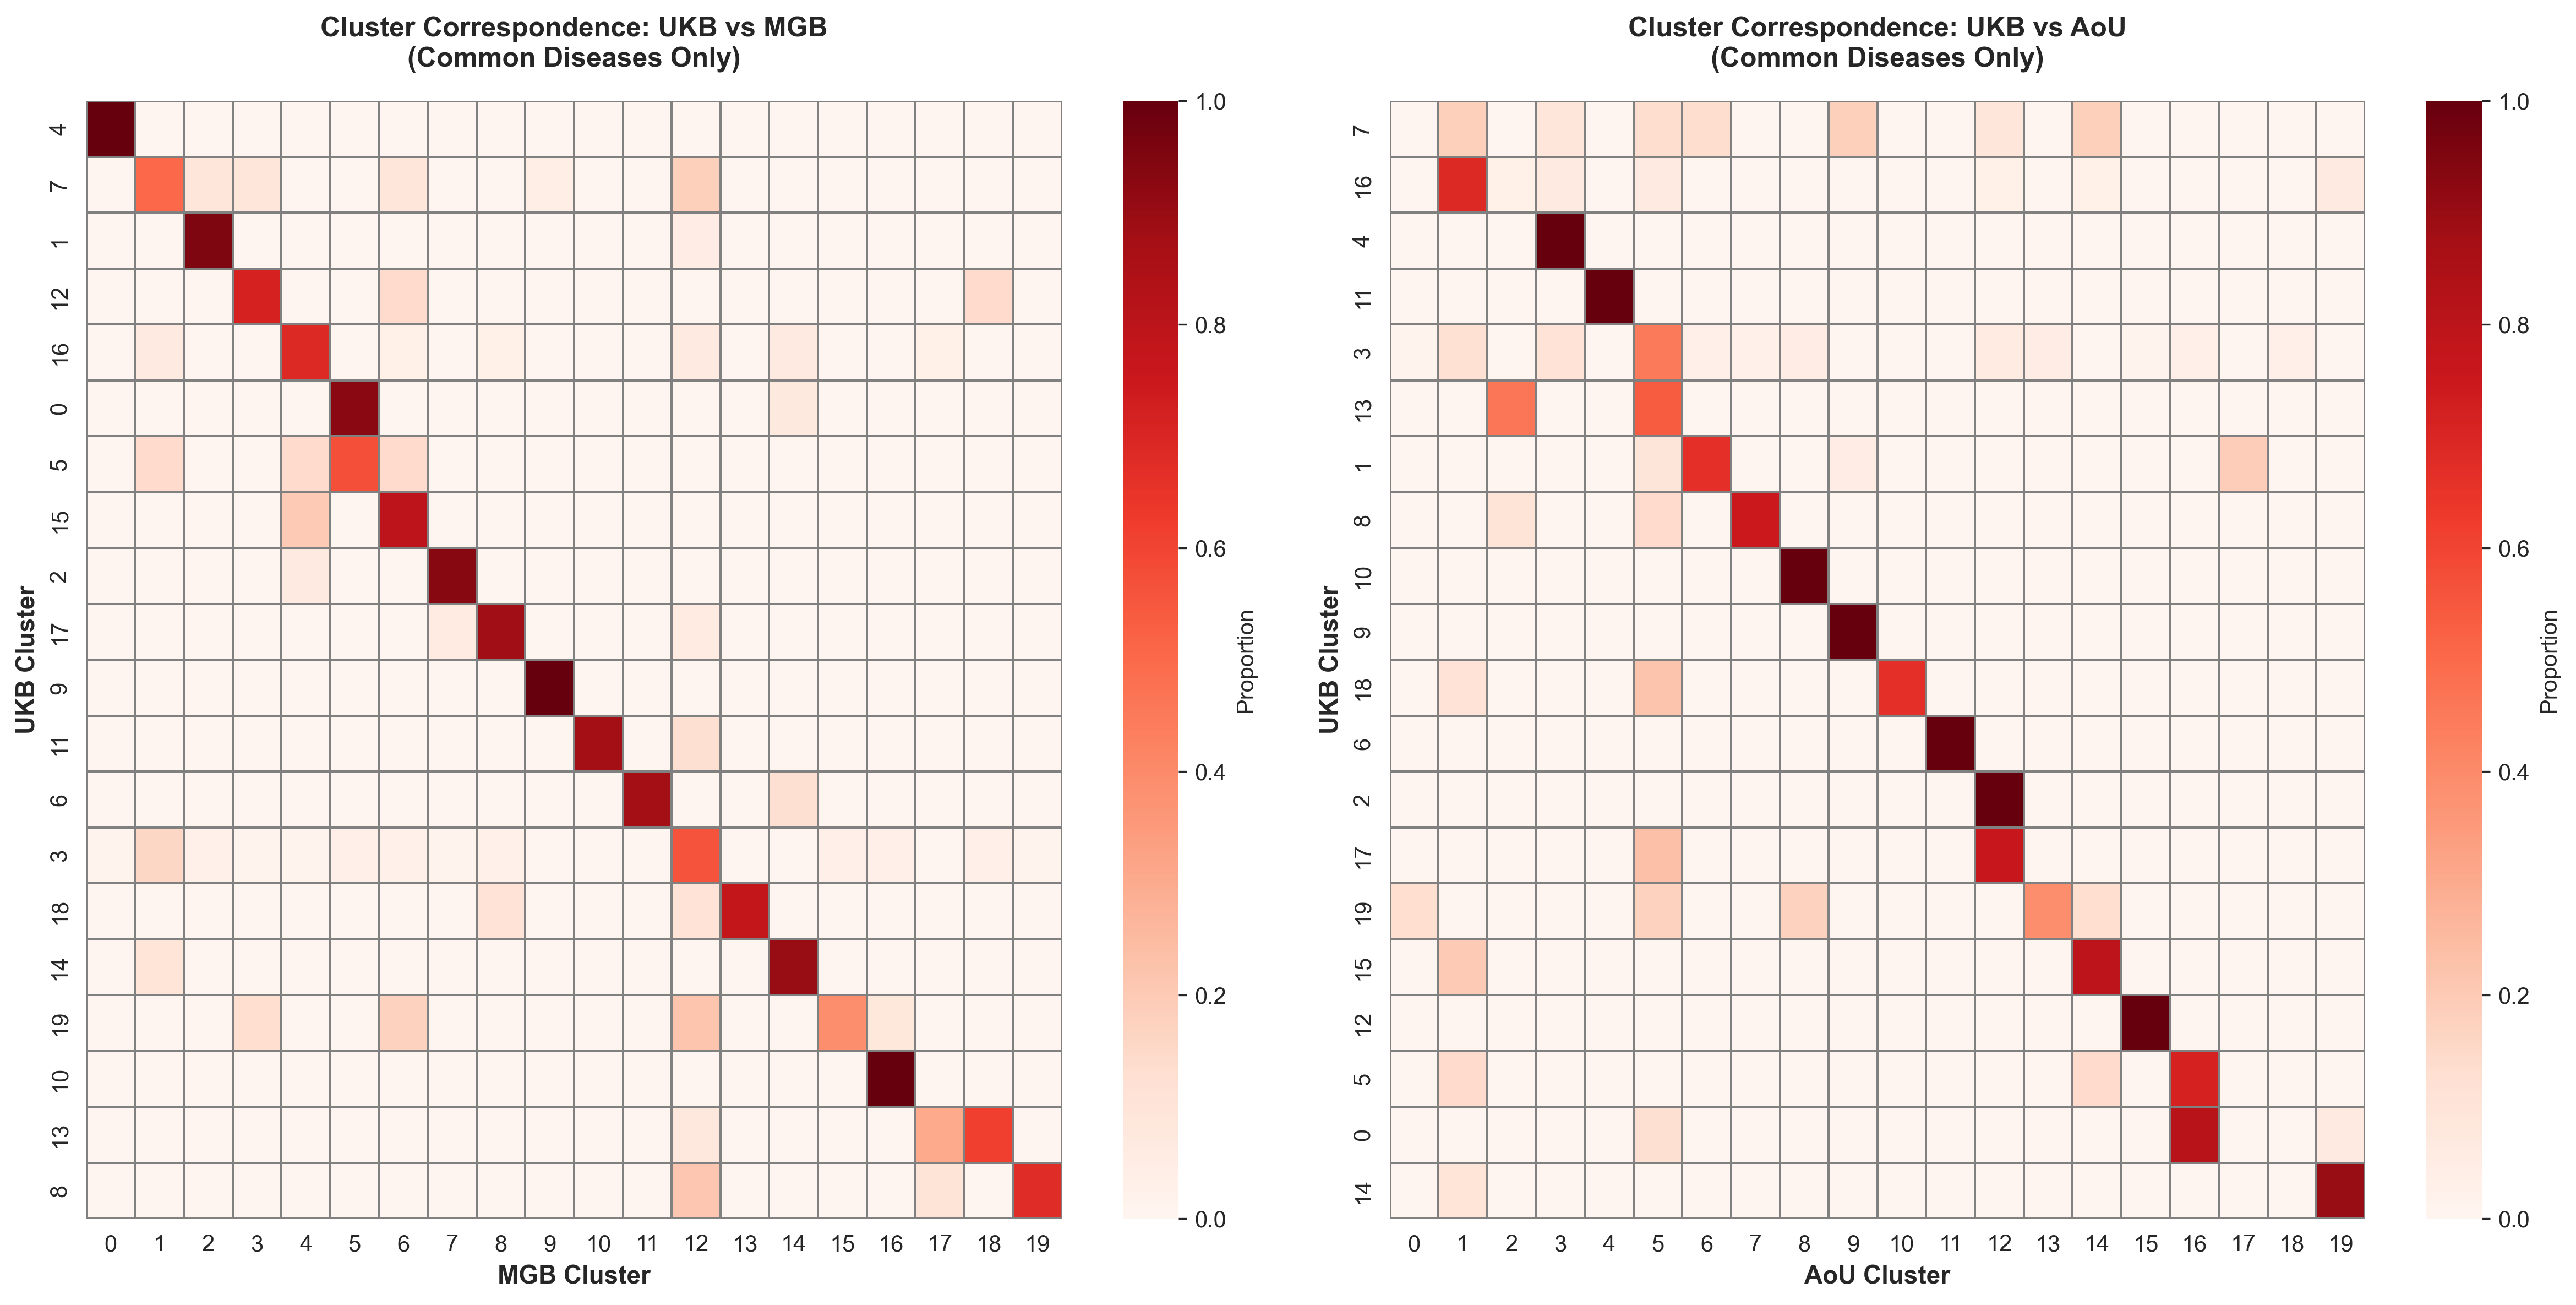

In [33]:
# Create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# UKB vs MGB
sns.heatmap(
    cross_tab_mgb.loc[best_matches_mgb['UKB']],
    cmap='Reds',
    vmin=0, vmax=1,
    ax=ax1,
    cbar_kws={'label': 'Proportion'},
    linewidths=0.5,
    linecolor='gray'
)
ax1.set_title('Cluster Correspondence: UKB vs MGB\n(Common Diseases Only)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.set_xlabel('MGB Cluster', fontsize=11, fontweight='bold')
ax1.set_ylabel('UKB Cluster', fontsize=11, fontweight='bold')

# UKB vs AoU
sns.heatmap(
    cross_tab_aou.loc[best_matches_aou['UKB']],
    cmap='Reds',
    vmin=0, vmax=1,
    ax=ax2,
    cbar_kws={'label': 'Proportion'},
    linewidths=0.5,
    linecolor='gray'
)
ax2.set_title('Cluster Correspondence: UKB vs AoU\n(Common Diseases Only)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.set_xlabel('AoU Cluster', fontsize=11, fontweight='bold')
ax2.set_ylabel('UKB Cluster', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cross_cohort_correspondence_heatmaps.pdf', 
            dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'cross_cohort_correspondence_heatmaps.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved heatmaps to: {OUTPUT_DIR / 'cross_cohort_correspondence_heatmaps.pdf'}")
plt.show()


### 2. Jaccard Similarity by Cluster


✓ Saved bar plots to: jaccard_similarity_by_cluster.pdf


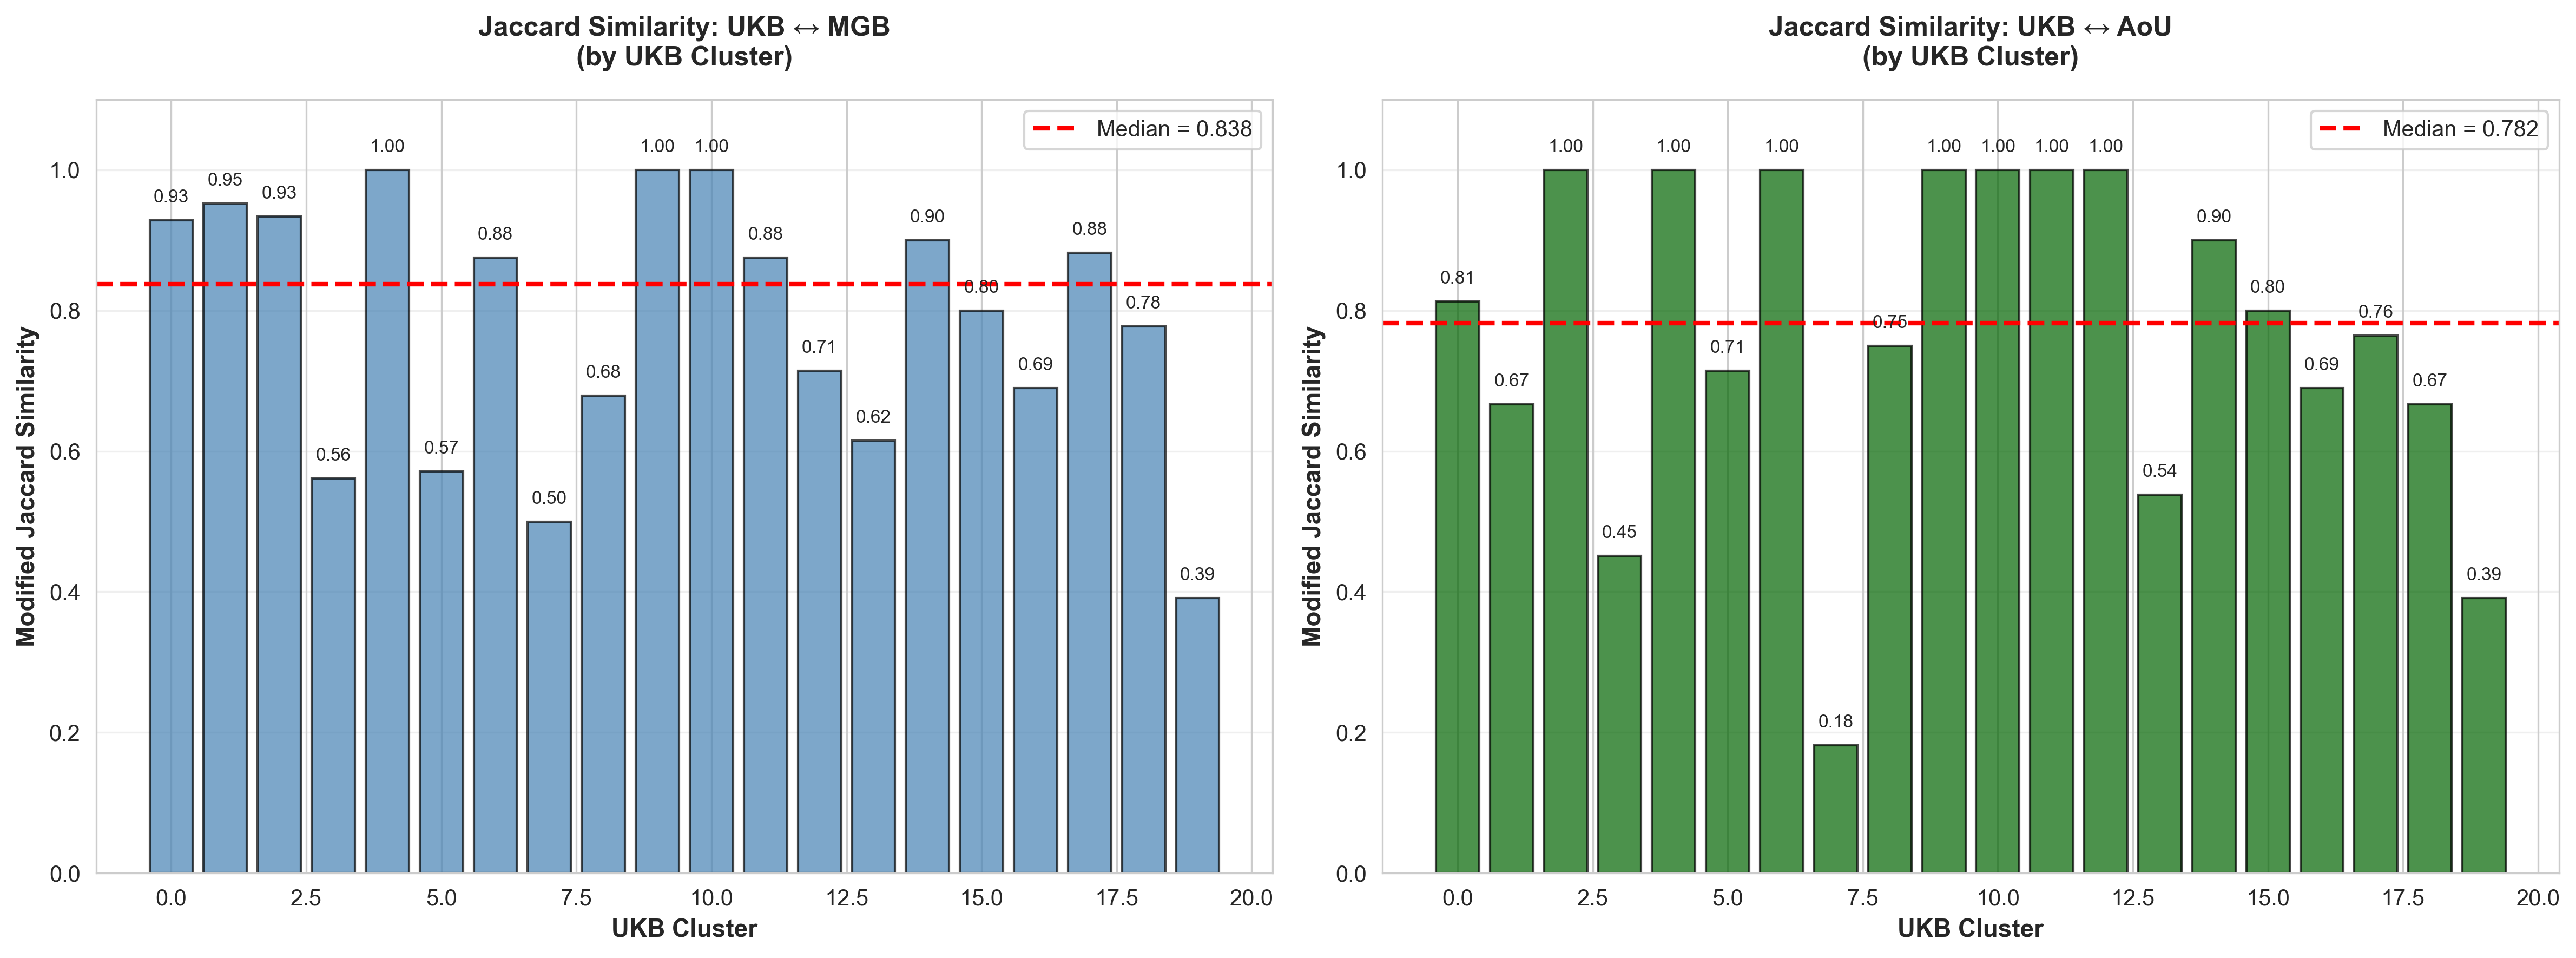

In [34]:
# Create bar plot of Jaccard similarities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data
ukb_clusters_mgb = sorted([k for k in details_mgb.keys()])
jaccard_values_mgb = [details_mgb[k]['jaccard'] for k in ukb_clusters_mgb]

ukb_clusters_aou = sorted([k for k in details_aou.keys()])
jaccard_values_aou = [details_aou[k]['jaccard'] for k in ukb_clusters_aou]

# UKB vs MGB
bars1 = ax1.bar(ukb_clusters_mgb, jaccard_values_mgb, 
                color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)
ax1.axhline(y=median_mgb, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {median_mgb:.3f}')
ax1.set_xlabel('UKB Cluster', fontsize=11, fontweight='bold')
ax1.set_ylabel('Modified Jaccard Similarity', fontsize=11, fontweight='bold')
ax1.set_title('Jaccard Similarity: UKB ↔ MGB\n(by UKB Cluster)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.set_ylim([0, 1.1])
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, jaccard_values_mgb)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=8)

# UKB vs AoU
bars2 = ax2.bar(ukb_clusters_aou, jaccard_values_aou, 
                color='darkgreen', alpha=0.7, edgecolor='black', linewidth=1)
ax2.axhline(y=median_aou, color='red', linestyle='--', linewidth=2, 
            label=f'Median = {median_aou:.3f}')
ax2.set_xlabel('UKB Cluster', fontsize=11, fontweight='bold')
ax2.set_ylabel('Modified Jaccard Similarity', fontsize=11, fontweight='bold')
ax2.set_title('Jaccard Similarity: UKB ↔ AoU\n(by UKB Cluster)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.set_ylim([0, 1.1])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars2, jaccard_values_aou)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'jaccard_similarity_by_cluster.pdf', 
            dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'jaccard_similarity_by_cluster.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved bar plots to: {OUTPUT_DIR / 'jaccard_similarity_by_cluster.pdf'}")
plt.show()


### 3. Distribution of Jaccard Similarities


✓ Saved distribution plot to: jaccard_similarity_distribution.pdf


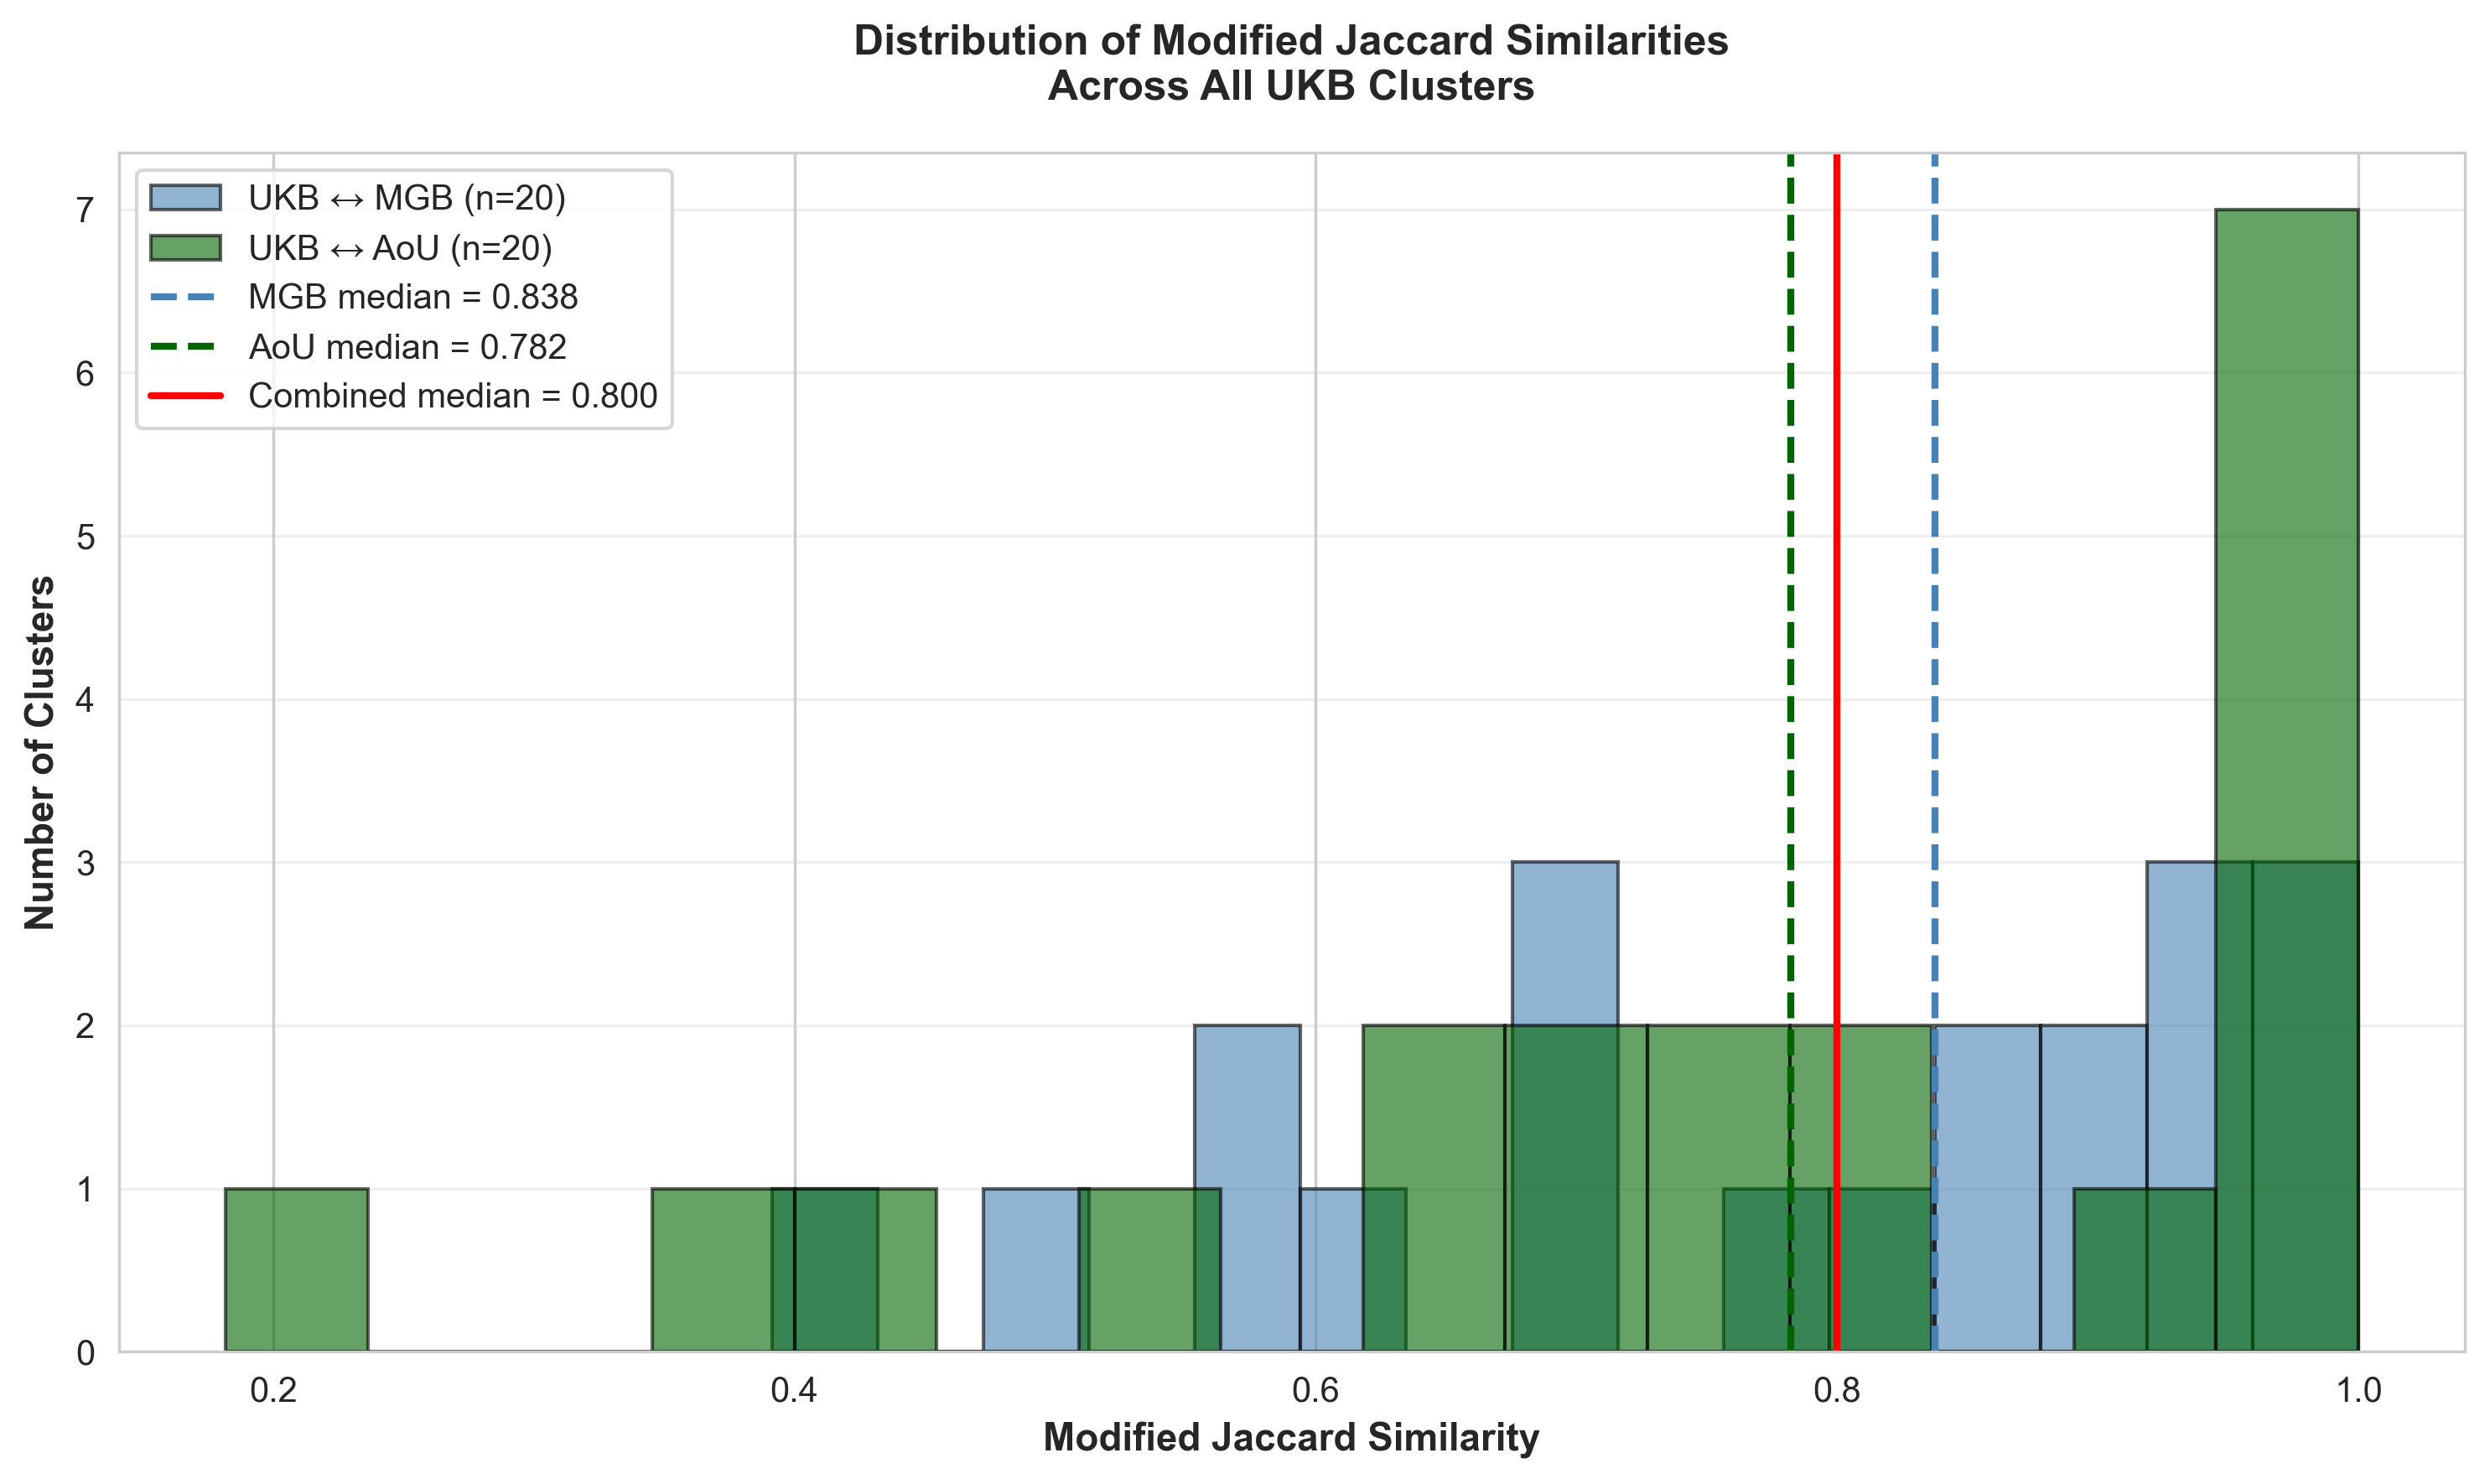

In [35]:
# Create distribution plot
fig, ax = plt.subplots(figsize=(10, 6))

# Combine all Jaccard scores
all_jaccard = jaccard_mgb + jaccard_aou

# Create histogram with KDE
ax.hist(jaccard_mgb, bins=15, alpha=0.6, label=f'UKB ↔ MGB (n={len(jaccard_mgb)})', 
        color='steelblue', edgecolor='black', linewidth=1)
ax.hist(jaccard_aou, bins=15, alpha=0.6, label=f'UKB ↔ AoU (n={len(jaccard_aou)})', 
        color='darkgreen', edgecolor='black', linewidth=1)

# Add median lines
ax.axvline(x=median_mgb, color='steelblue', linestyle='--', linewidth=2, 
           label=f'MGB median = {median_mgb:.3f}')
ax.axvline(x=median_aou, color='darkgreen', linestyle='--', linewidth=2, 
           label=f'AoU median = {median_aou:.3f}')
ax.axvline(x=combined_median, color='red', linestyle='-', linewidth=2, 
           label=f'Combined median = {combined_median:.3f}')

ax.set_xlabel('Modified Jaccard Similarity', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Clusters', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Modified Jaccard Similarities\nAcross All UKB Clusters', 
              fontsize=12, fontweight='bold', pad=15)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'jaccard_similarity_distribution.pdf', 
            dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_DIR / 'jaccard_similarity_distribution.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Saved distribution plot to: {OUTPUT_DIR / 'jaccard_similarity_distribution.pdf'}")
plt.show()


In [36]:
# Create summary table
summary_data = {
    'Comparison': ['UKB ↔ MGB', 'UKB ↔ AoU', 'Combined'],
    'Median Jaccard': [f'{median_mgb:.3f}', f'{median_aou:.3f}', f'{combined_median:.3f}'],
    'Median %': [f'{median_mgb*100:.1f}%', f'{median_aou*100:.1f}%', f'{combined_median*100:.1f}%'],
    'IQR': [
        f"[{np.percentile(jaccard_mgb, 25):.3f}, {np.percentile(jaccard_mgb, 75):.3f}]",
        f"[{np.percentile(jaccard_aou, 25):.3f}, {np.percentile(jaccard_aou, 75):.3f}]",
        f"[{np.percentile(all_jaccard, 25):.3f}, {np.percentile(all_jaccard, 75):.3f}]"
    ],
    'N Clusters': [len(jaccard_mgb), len(jaccard_aou), len(all_jaccard)],
    'Common Diseases': [len(common_ukb_mgb), len(common_ukb_aou), len(common_all_three)]
}

summary_df = pd.DataFrame(summary_data)
print("="*80)
print("SUMMARY TABLE")
print("="*80)
print("\n", summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(OUTPUT_DIR / 'cross_cohort_similarity_summary.csv', index=False)
print(f"\n✓ Saved summary table to: {OUTPUT_DIR / 'cross_cohort_similarity_summary.csv'}")


SUMMARY TABLE

 Comparison Median Jaccard Median %            IQR  N Clusters  Common Diseases
 UKB ↔ MGB          0.838    83.8% [0.663, 0.930]          20              346
 UKB ↔ AoU          0.782    78.2% [0.667, 1.000]          20              348
  Combined          0.800    80.0% [0.667, 0.964]          40              346

✓ Saved summary table to: cross_cohort_similarity_summary.csv


## Key Findings

1. **Strong cross-cohort correspondence**: Median modified Jaccard similarity of **0.800 (80.0%)** across all UKB signatures

2. **Consistent patterns**: Both MGB and AoU show similar levels of correspondence with UKB (83.8% and 77.5% respectively)

3. **Robust biological signatures**: The high correspondence suggests that disease signatures represent robust biological patterns that transcend population differences

4. **Methodology**: The modified Jaccard similarity uses set intersections to quantify the proportion of diseases in each UKB cluster that are also found in the best-matching cluster in the comparison cohort
